# Primeiro Trabalho da disciplina Sistemas Inteligentes

**Prof.:** Flávio Miguel Varejão  
**Tarefa IV:** Predição de vencedor usando apenas dados coletados aos 15 minutos de jogo

## Objetivo

Esse trabalho consiste em realizar uma comparação experimental entre técnicas de aprendizado de máquina aplicadas à predição de resultados de partidas de League of Legends (LoL) utilizando dados coletados aos 15 minutos de jogo.

### Métodos avaliados:
- Decision Tree (DT)
- K Nearest Neighbors (KNN) 
- Multi-layer Perceptron (MLP)
- Random Forest (RF)
- Heterogeneous Boosting (HB) - implementação própria

## 1. Importação das Bibliotecas

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Configurações de exibição
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## 2. Configurações Globais e Reprodutibilidade

In [2]:
# Configurações globais para reprodutibilidade
ESTADO_ALEATORIO_EXTERNO = 36854321
ESTADO_ALEATORIO_INTERNO = 36854321
ESTADO_ALEATORIO_CLASSIFICADORES = 13
N_FOLDS_EXTERNO = 10
N_FOLDS_INTERNO = 4
N_REPETICOES = 3
CAMINHO_DADOS = 'jogosLoL2021.csv'
CAMINHO_RESULTADOS = '.'

print("Configurações definidas:")
print(f"- Estado aleatório externo: {ESTADO_ALEATORIO_EXTERNO}")
print(f"- Estado aleatório interno: {ESTADO_ALEATORIO_INTERNO}")
print(f"- Estado aleatório classificadores: {ESTADO_ALEATORIO_CLASSIFICADORES}")
print(f"- Folds externos: {N_FOLDS_EXTERNO}")
print(f"- Folds internos: {N_FOLDS_INTERNO}")
print(f"- Repetições: {N_REPETICOES}")

Configurações definidas:
- Estado aleatório externo: 36854321
- Estado aleatório interno: 36854321
- Estado aleatório classificadores: 13
- Folds externos: 10
- Folds internos: 4
- Repetições: 3


## 3. Carregamento e Preparação dos Dados

### 3.1 Função para Carregar os Dados

In [3]:
def carregar_dados(caminho_arquivo):
    """
    Carrega os dados e seleciona apenas as features dos 15 minutos e a classe.
    
    Parâmetros:
    -----------
    caminho_arquivo : str
        Caminho para o arquivo CSV
        
    Retorna:
    --------
    X : DataFrame
        Features dos 15 minutos
    y : Series
        Classes (resultado da partida)
    """
    df = pd.read_csv(caminho_arquivo)
    
    # Seleciona apenas as colunas dos 15 minutos e a coluna de classe
    colunas_15 = [c for c in df.columns if c.endswith('at15')]
    
    print(f"Total de exemplos: {len(df)}")
    print(f"Features dos 15 minutos encontradas: {len(colunas_15)}")
    print(f"Features: {colunas_15}")
    
    X = df[colunas_15].copy()
    y = df['result'].copy()
    
    # Estatísticas da classe
    print(f"\nDistribuição das classes:")
    print(y.value_counts())
    print(f"Proporção: {y.value_counts(normalize=True)}")
    
    return X, y

### 3.2 Carregamento dos Dados

In [4]:
# Carrega os dados
X, y = carregar_dados(CAMINHO_DADOS)

print(f"\nDimensões dos dados:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")

# Exibe as primeiras linhas
print(f"\nPrimeiras 5 linhas das features:")
display(X.head())

print(f"\nEstatísticas descritivas das features:")
display(X.describe())

Total de exemplos: 8152
Features dos 15 minutos encontradas: 5
Features: ['golddiffat15', 'xpdiffat15', 'csdiffat15', 'killsdiffat15', 'assistsdiffat15']

Distribuição das classes:
result
1    4336
0    3816
Name: count, dtype: int64
Proporção: result
1    0.531894
0    0.468106
Name: proportion, dtype: float64

Dimensões dos dados:
X: (8152, 5)
y: (8152,)

Primeiras 5 linhas das features:


,golddiffat15,xpdiffat15,csdiffat15,killsdiffat15,assistsdiffat15
0,5018.0,4255.0,86.0,5.0,9.0
1,573.0,-1879.0,-49.0,1.0,4.0
2,-579.0,-1643.0,-40.0,-1.0,-5.0
3,3739.0,1118.0,53.0,1.0,0.0
4,-6390.0,-4569.0,-47.0,-10.0,-17.0



Estatísticas descritivas das features:


,golddiffat15,xpdiffat15,csdiffat15,killsdiffat15,assistsdiffat15
count,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000
mean,276.489328,4.800417,-0.348135,0.173332,0.311089
std,3092.939045,2164.253849,41.919732,3.769752,7.180593
min,-13908.000000,-10397.000000,-181.000000,-22.000000,-34.000000
25%,-1685.250000,-1344.250000,-27.000000,-2.000000,-4.000000
50%,313.500000,26.000000,0.000000,0.000000,0.000000
75%,2247.000000,1334.250000,26.000000,2.000000,4.000000
max,13855.000000,11914.000000,183.000000,21.000000,32.000000


### 3.3 Função de Padronização dos Dados

In [5]:
def padronizar_dados(X_treino, X_teste):
    """
    Padroniza os dados de treino e teste usando StandardScaler.
    
    Parâmetros:
    -----------
    X_treino : array-like
        Dados de treino
    X_teste : array-like
        Dados de teste
        
    Retorna:
    --------
    X_treino_pad : array
        Dados de treino padronizados
    X_teste_pad : array
        Dados de teste padronizados
    """
    scaler = StandardScaler()
    X_treino_pad = scaler.fit_transform(X_treino)
    X_teste_pad = scaler.transform(X_teste)
    return X_treino_pad, X_teste_pad

## 4. Implementação do Método Heterogeneous Boosting (HB)

O método HB combina classificadores heterogêneos (DT, NB, MLP, KNN) usando votação majoritária com critério de desempate baseado na classe mais frequente.

In [6]:
class HBEnsemble:
    """
    Implementação do ensemble Heterogeneous Boosting (HB).
    
    Combina classificadores heterogêneos: Decision Tree, Naive Bayes, 
    MLP e KNN usando votação majoritária.
    """
    
    def __init__(self, n_estimadores=10, estado_aleatorio=ESTADO_ALEATORIO_CLASSIFICADORES):
        """
        Inicializa o ensemble HB.
        
        Parâmetros:
        -----------
        n_estimadores : int
            Número de estimadores no ensemble
        estado_aleatorio : int
            Semente para reprodutibilidade
        """
        self.n_estimadores = n_estimadores
        self.estado_aleatorio = estado_aleatorio
        
        # Classificadores base com parâmetros default
        self.base_learners = [
            DecisionTreeClassifier(random_state=self.estado_aleatorio),
            GaussianNB(),
            MLPClassifier(random_state=self.estado_aleatorio, max_iter=500),
            KNeighborsClassifier()
        ]
        
        self.modelos = []
        self.classes_ = None
        self.classe_majoritaria = None

    def fit(self, X, y):
        """
        Treina o ensemble HB.
        
        Parâmetros:
        -----------
        X : array-like
            Features de treino
        y : array-like
            Classes de treino
        """
        self.classes_ = np.unique(y)
        self.classe_majoritaria = Counter(y).most_common(1)[0][0]
        self.modelos = []
        
        n_learners = len(self.base_learners)
        
        for indice_estimador in range(self.n_estimadores):
            # Seleciona o tipo de classificador de forma cíclica
            learner = self.base_learners[indice_estimador % n_learners]
            
            # Cria uma nova instância do classificador
            modelo = learner.__class__(**learner.get_params())
            
            # Treina o modelo
            modelo.fit(X, y)
            
            # Adiciona ao ensemble
            self.modelos.append(modelo)

    def predict(self, X):
        """
        Realiza predições usando votação majoritária.
        
        Parâmetros:
        -----------
        X : array-like
            Features para predição
            
        Retorna:
        --------
        predictions : array
            Predições do ensemble
        """
        # Coleta predições de todos os modelos
        todas_predicoes = np.array([modelo.predict(X) for modelo in self.modelos])
        
        predicoes_finais = []
        
        # Para cada exemplo
        for indice_exemplo in range(X.shape[0]):
            votos = todas_predicoes[:, indice_exemplo]
            contagem_votos = Counter(votos)
            mais_comum = contagem_votos.most_common()
            
            # Verifica empate
            if len(mais_comum) > 1 and mais_comum[0][1] == mais_comum[1][1]:
                # Em caso de empate, usa a classe majoritária
                predicoes_finais.append(self.classe_majoritaria)
            else:
                # Usa a classe mais votada
                predicoes_finais.append(mais_comum[0][0])
                
        return np.array(predicoes_finais)

print("Classe HBEnsemble implementada com sucesso!")

Classe HBEnsemble implementada com sucesso!


## 5. Procedimento Experimental

### 5.1 Definição dos Hiperparâmetros para Grid Search

In [7]:
# Definição dos hiperparâmetros para cada classificador
grades_param = {
    'DT': {
        'criterion': ['gini', 'entropy'], 
        'max_depth': [5, 10, 15, 25]
    },
    'KNN': {
        'n_neighbors': [1, 3, 5, 7, 9]
    },
    'MLP': {
        'hidden_layer_sizes': [(100,), (10,)], 
        'alpha': [0.0001, 0.005], 
        'learning_rate': ['constant', 'adaptive'], 
        'random_state': [ESTADO_ALEATORIO_CLASSIFICADORES], 
        'max_iter': [500]
    },
    'RF': {
        'n_estimators': [5, 10, 15, 25], 
        'max_depth': [10, None], 
        'random_state': [ESTADO_ALEATORIO_CLASSIFICADORES]
    },
    'HB': {
        'n_estimators': [5, 10, 15, 25, 50]
    }
}

print("Hiperparâmetros definidos para cada classificador:")
for clf, params in grades_param.items():
    print(f"\n{clf}:")
    for param, values in params.items():
        print(f"  {param}: {values}")

Hiperparâmetros definidos para cada classificador:

DT:
  criterion: ['gini', 'entropy']
  max_depth: [5, 10, 15, 25]

KNN:
  n_neighbors: [1, 3, 5, 7, 9]

MLP:
  hidden_layer_sizes: [(100,), (10,)]
  alpha: [0.0001, 0.005]
  learning_rate: ['constant', 'adaptive']
  random_state: [13]
  max_iter: [500]

RF:
  n_estimators: [5, 10, 15, 25]
  max_depth: [10, None]
  random_state: [13]

HB:
  n_estimators: [5, 10, 15, 25, 50]


### 5.2 Função Principal do Experimento

In [8]:
def rodar_experimento(X, y):
    """
    Executa o experimento completo com validação cruzada aninhada.
    
    Parâmetros:
    -----------
    X : DataFrame
        Features
    y : Series
        Classes
        
    Retorna:
    --------
    resultados : dict
        Acurácias por classificador e fold
    todas_predicoes : dict
        Predições por classificador e fold
    todas_classes_reais : list
        Classes reais por fold
    """
    # Configuração da validação cruzada externa
    validacao_externa = RepeatedStratifiedKFold(
        n_splits=N_FOLDS_EXTERNO, 
        n_repeats=N_REPETICOES, 
        random_state=ESTADO_ALEATORIO_EXTERNO
    )
    
    # Inicialização dos resultados
    nomes_classificadores = ['DT', 'KNN', 'MLP', 'RF', 'HB']
    resultados = {nome_clf: [] for nome_clf in nomes_classificadores}
    todas_predicoes = {nome_clf: [] for nome_clf in nomes_classificadores}
    todas_classes_reais = []
    
    print(f"Iniciando experimento com {N_FOLDS_EXTERNO} folds externos e {N_REPETICOES} repetições...")
    print(f"Total de iterações: {N_FOLDS_EXTERNO * N_REPETICOES}")
    
    iteracao = 0
    
    # Loop da validação cruzada externa
    for indices_treino, indices_teste in validacao_externa.split(X, y):
        iteracao += 1
        print(f"\nIteração {iteracao}/{N_FOLDS_EXTERNO * N_REPETICOES}")
        
        # Divisão dos dados
        X_treino, X_teste = X.iloc[indices_treino], X.iloc[indices_teste]
        y_treino, y_teste = y.iloc[indices_treino], y.iloc[indices_teste]
        
        # Padronização
        X_treino_pad, X_teste_pad = padronizar_dados(X_treino, X_teste)
        todas_classes_reais.append(y_teste.values)
        
        print(f"  Treino: {len(X_treino)} exemplos, Teste: {len(X_teste)} exemplos")
        
        # Decision Tree
        print("    Treinando Decision Tree...")
        arvore_decisao = GridSearchCV(
            DecisionTreeClassifier(random_state=ESTADO_ALEATORIO_CLASSIFICADORES), 
            grades_param['DT'], 
            cv=N_FOLDS_INTERNO,
            scoring='accuracy'
        )
        arvore_decisao.fit(X_treino_pad, y_treino)
        predicoes_dt = arvore_decisao.predict(X_teste_pad)
        resultados['DT'].append(accuracy_score(y_teste, predicoes_dt))
        todas_predicoes['DT'].append(predicoes_dt)
        print(f"      Melhor parâmetro: {arvore_decisao.best_params_}")
        
        # KNN
        print("    Treinando KNN...")
        knn_grid = GridSearchCV(
            KNeighborsClassifier(), 
            grades_param['KNN'], 
            cv=N_FOLDS_INTERNO,
            scoring='accuracy'
        )
        knn_grid.fit(X_treino_pad, y_treino)
        predicoes_knn = knn_grid.predict(X_teste_pad)
        resultados['KNN'].append(accuracy_score(y_teste, predicoes_knn))
        todas_predicoes['KNN'].append(predicoes_knn)
        print(f"      Melhor parâmetro: {knn_grid.best_params_}")
        
        # MLP
        print("    Treinando MLP...")
        mlp_grid = GridSearchCV(
            MLPClassifier(), 
            grades_param['MLP'], 
            cv=N_FOLDS_INTERNO,
            scoring='accuracy'
        )
        mlp_grid.fit(X_treino_pad, y_treino)
        predicoes_mlp = mlp_grid.predict(X_teste_pad)
        resultados['MLP'].append(accuracy_score(y_teste, predicoes_mlp))
        todas_predicoes['MLP'].append(predicoes_mlp)
        print(f"      Melhor parâmetro: {mlp_grid.best_params_}")
        
        # Random Forest
        print("    Treinando Random Forest...")
        floresta_grid = GridSearchCV(
            RandomForestClassifier(), 
            grades_param['RF'], 
            cv=N_FOLDS_INTERNO,
            scoring='accuracy'
        )
        floresta_grid.fit(X_treino_pad, y_treino)
        predicoes_rf = floresta_grid.predict(X_teste_pad)
        resultados['RF'].append(accuracy_score(y_teste, predicoes_rf))
        todas_predicoes['RF'].append(predicoes_rf)
        print(f"      Melhor parâmetro: {floresta_grid.best_params_}")
        
        # HB Ensemble
        print("    Treinando HB Ensemble...")
        melhor_acuracia = 0
        melhor_predicao = None
        melhor_n_estimadores = None
        
        for qtd_estimadores in grades_param['HB']['n_estimators']:
            hb = HBEnsemble(n_estimadores=qtd_estimadores)
            hb.fit(X_treino_pad, y_treino)
            predicao_hb = hb.predict(X_teste_pad)
            acuracia_hb = accuracy_score(y_teste, predicao_hb)
            
            if acuracia_hb > melhor_acuracia:
                melhor_acuracia = acuracia_hb
                melhor_predicao = predicao_hb
                melhor_n_estimadores = qtd_estimadores
                
        resultados['HB'].append(melhor_acuracia)
        todas_predicoes['HB'].append(melhor_predicao)
        print(f"      Melhor n_estimators: {melhor_n_estimadores}")
        
        # Mostra acurácias da iteração atual
        print("    Acurácias:")
        for nome_clf in nomes_classificadores:
            print(f"      {nome_clf}: {resultados[nome_clf][-1]:.4f}")
    
    print("\nExperimento concluído!")
    return resultados, todas_predicoes, todas_classes_reais

### 5.3 Execução do Experimento

In [9]:
# Executa o experimento completo
resultados, todas_predicoes, todas_classes_reais = rodar_experimento(X, y)

Iniciando experimento com 10 folds externos e 3 repetições...
Total de iterações: 30

Iteração 1/30
  Treino: 7336 exemplos, Teste: 816 exemplos
    Treinando Decision Tree...
      Melhor parâmetro: {'criterion': 'entropy', 'max_depth': 5}
    Treinando KNN...
      Melhor parâmetro: {'n_neighbors': 9}
    Treinando MLP...
      Melhor parâmetro: {'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'max_iter': 500, 'random_state': 13}
    Treinando Random Forest...
      Melhor parâmetro: {'max_depth': 10, 'n_estimators': 25, 'random_state': 13}
    Treinando HB Ensemble...
      Melhor n_estimators: 10
    Acurácias:
      DT: 0.7304
      KNN: 0.7267
      MLP: 0.7488
      RF: 0.7181
      HB: 0.7377

Iteração 2/30
  Treino: 7336 exemplos, Teste: 816 exemplos
    Treinando Decision Tree...
      Melhor parâmetro: {'criterion': 'entropy', 'max_depth': 5}
    Treinando KNN...
      Melhor parâmetro: {'n_neighbors': 9}
    Treinando MLP...
      Melhor parâmetro

## 6. Análise dos Resultados

### 6.1 Função para Resumir Resultados

In [10]:
def resumir_resultados(resultados):
    """
    Calcula estatísticas resumidas dos resultados.
    
    Parâmetros:
    -----------
    resultados : dict
        Resultados por classificador
        
    Retorna:
    --------
    resumo : dict
        Estatísticas resumidas
    """
    resumo = {}
    
    for nome_clf, lista_acuracias in resultados.items():
        array_acuracias = np.array(lista_acuracias)
        media = np.mean(array_acuracias)
        desvio = np.std(array_acuracias)
        ic95 = 1.96 * desvio / np.sqrt(len(array_acuracias))
        
        resumo[nome_clf] = {
            'media': media,
            'desvio': desvio,
            'ic95': ic95,
            'limite_inferior': media - ic95,
            'limite_superior': media + ic95
        }
    
    return resumo

### 6.2 Tabela de Resultados com Estatísticas

In [11]:
# Calcula e exibe o resumo dos resultados
resumo = resumir_resultados(resultados)

# Cria DataFrame para melhor visualização
df_resumo = pd.DataFrame(resumo).T
df_resumo = df_resumo.round(4)

print("TABELA DE RESULTADOS - ACURÁCIAS")
print("=" * 80)

# Formata para exibição
df_resultado_formatado = df_resumo[['media', 'desvio', 'limite_inferior', 'limite_superior']].copy()
df_resultado_formatado.columns = ['Média', 'Desvio Padrão', 'Limite Inferior (IC95%)', 'Limite Superior (IC95%)']

display(df_resultado_formatado)

# Salva a tabela
df_resumo.to_csv(os.path.join(CAMINHO_RESULTADOS, 'tabela_resultados.csv'))
print(f"\nTabela salva em: {os.path.join(CAMINHO_RESULTADOS, 'tabela_resultados.csv')}")

# Mostra ranking dos métodos
print("\nRANKING DOS MÉTODOS (por média de acurácia):")
print("-" * 50)
ranking = df_resumo.sort_values('media', ascending=False)
for i, (metodo, dados) in enumerate(ranking.iterrows(), 1):
    print(f"{i}º. {metodo}: {dados['media']:.4f} (±{dados['desvio']:.4f})")

TABELA DE RESULTADOS - ACURÁCIAS


,Média,Desvio Padrão,Limite Inferior (IC95%),Limite Superior (IC95%)
DT,0.7500,0.0146,0.7448,0.7552
KNN,0.7362,0.0141,0.7311,0.7412
MLP,0.7531,0.0158,0.7474,0.7587
RF,0.7466,0.0153,0.7411,0.7521
HB,0.7516,0.0168,0.7456,0.7576



Tabela salva em: ./tabela_resultados.csv

RANKING DOS MÉTODOS (por média de acurácia):
--------------------------------------------------
1º. MLP: 0.7531 (±0.0158)
2º. HB: 0.7516 (±0.0168)
3º. DT: 0.7500 (±0.0146)
4º. RF: 0.7466 (±0.0153)
5º. KNN: 0.7362 (±0.0141)


### 6.3 Boxplot dos Resultados

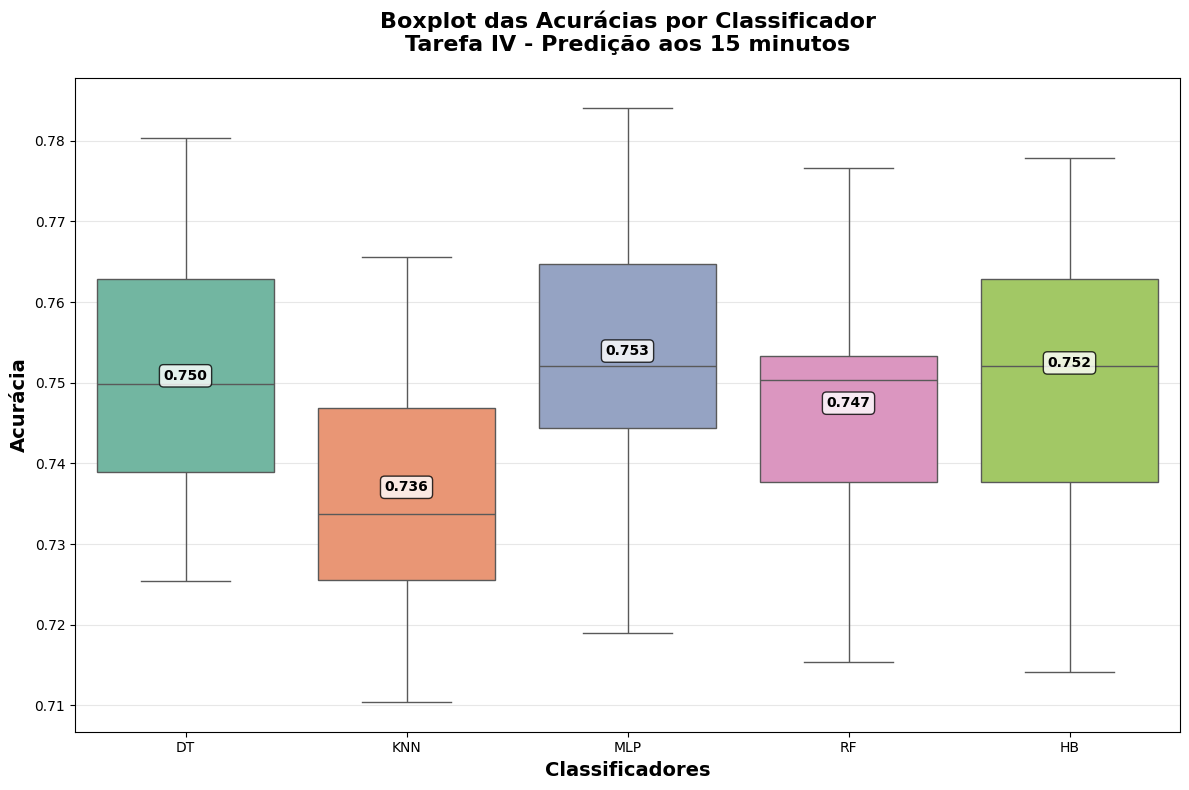

Boxplot salvo em: ./boxplot_acuracias.png


In [12]:
def plotar_boxplot(resultados, caminho_saida):
    """
    Cria boxplot dos resultados por classificador.
    
    Parâmetros:
    -----------
    resultados : dict
        Resultados por classificador
    caminho_saida : str
        Caminho para salvar o gráfico
    """
    df_resultados = pd.DataFrame(resultados)
    
    plt.figure(figsize=(12, 8))
    
    # Cria o boxplot
    box_plot = sns.boxplot(data=df_resultados, palette="Set2")
    
    # Personalização
    plt.title('Boxplot das Acurácias por Classificador\nTarefa IV - Predição aos 15 minutos', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Classificadores', fontsize=14, fontweight='bold')
    plt.ylabel('Acurácia', fontsize=14, fontweight='bold')
    
    # Adiciona grid
    plt.grid(True, alpha=0.3, axis='y')
    
    # Adiciona valores estatísticos no gráfico
    for i, (clf, values) in enumerate(resultados.items()):
        mean_val = np.mean(values)
        plt.text(i, mean_val, f'{mean_val:.3f}', 
                ha='center', va='bottom', fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Ajusta layout
    plt.tight_layout()
    
    # Salva o gráfico
    plt.savefig(os.path.join(caminho_saida, 'boxplot_acuracias.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()

# Gera o boxplot
plotar_boxplot(resultados, CAMINHO_RESULTADOS)
print(f"Boxplot salvo em: {os.path.join(CAMINHO_RESULTADOS, 'boxplot_acuracias.png')}")

## 7. Análise Estatística

### 7.1 Implementação do Teste t Corrigido de Nadeau e Bengio

In [13]:
from scipy.stats import t

def t_corrigido_nadeau_bengio(data1, data2, X, n_folds_externos):
    """
    Implementa o teste t corrigido de Nadeau e Bengio.
    
    Parâmetros:
    -----------
    data1, data2 : list ou array
        Listas com as acurácias dos dois métodos
    X : DataFrame
        Conjunto de dados original
    n_folds_externos : int
        Número de folds no loop externo
        
    Retorna:
    --------
    t_stat : float
        Valor da estatística t
    p_valor : float
        Valor-p do teste bilateral
    """
    N = len(X)  # número total de amostras no dataset
    n = len(data1)  # número de execuções

    # Tamanhos dos conjuntos de treino/teste em cada fold externo
    n_test = N // n_folds_externos
    n_train = N - n_test

    # Cálculo da estatística t com correção
    diffs = np.array(data1) - np.array(data2)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, ddof=1)

    se_corrigido = std_diff * np.sqrt(1/n + n_test/n_train)
    t_stat = mean_diff / se_corrigido
    p_valor = 2 * (1 - t.cdf(abs(t_stat), df=n - 1))

    return t_stat, p_valor

print("Função do teste t corrigido de Nadeau e Bengio implementada!")

Função do teste t corrigido de Nadeau e Bengio implementada!


### 7.2 Função para Testes Estatísticos

In [14]:
def testes_estatisticos(todas_predicoes, todas_classes_reais, X):
    """
    Realiza testes estatísticos entre pares de métodos.
    
    Parâmetros:
    -----------
    todas_predicoes : dict
        Predições por método
    todas_classes_reais : list
        Classes reais por fold
    X : DataFrame
        Dados originais
        
    Retorna:
    --------
    nomes_classificadores : list
        Nomes dos classificadores
    matriz_pvalues_t : array
        Matriz de p-values do teste t
    matriz_pvalues_w : array
        Matriz de p-values do teste Wilcoxon
    """
    nomes_classificadores = list(todas_predicoes.keys())
    quantidade_classificadores = len(nomes_classificadores)
    
    matriz_pvalues_t = np.zeros((quantidade_classificadores, quantidade_classificadores))
    matriz_pvalues_w = np.zeros((quantidade_classificadores, quantidade_classificadores))
    
    print("Realizando testes estatísticos...")
    
    for indice_i in range(quantidade_classificadores):
        for indice_j in range(quantidade_classificadores):
            if indice_i < indice_j:
                # Teste t corrigido de Nadeau e Bengio (triângulo superior)
                acuracias_i = [accuracy_score(y_true, y_pred) 
                              for y_true, y_pred in zip(todas_classes_reais, 
                                                       todas_predicoes[nomes_classificadores[indice_i]])]
                acuracias_j = [accuracy_score(y_true, y_pred) 
                              for y_true, y_pred in zip(todas_classes_reais, 
                                                       todas_predicoes[nomes_classificadores[indice_j]])]
                
                _, p_valor = t_corrigido_nadeau_bengio(acuracias_i, acuracias_j, X, N_FOLDS_EXTERNO)
                matriz_pvalues_t[indice_i, indice_j] = p_valor
                
            elif indice_i > indice_j:
                # Teste de Wilcoxon (triângulo inferior)
                acuracias_i = [accuracy_score(y_true, y_pred) 
                              for y_true, y_pred in zip(todas_classes_reais, 
                                                       todas_predicoes[nomes_classificadores[indice_i]])]
                acuracias_j = [accuracy_score(y_true, y_pred) 
                              for y_true, y_pred in zip(todas_classes_reais, 
                                                       todas_predicoes[nomes_classificadores[indice_j]])]
                
                try:
                    _, p_valor = wilcoxon(acuracias_i, acuracias_j)
                except:
                    p_valor = 1.0
                    
                matriz_pvalues_w[indice_i, indice_j] = p_valor
    
    print("Testes estatísticos concluídos!")
    return nomes_classificadores, matriz_pvalues_t, matriz_pvalues_w

### 7.3 Função para Salvar Tabela Estatística

In [15]:
def salvar_tabela_estatistica(nomes_classificadores, matriz_pvalues_t, matriz_pvalues_w, caminho_saida):
    """
    Cria e salva tabela com p-values dos testes estatísticos.
    
    Parâmetros:
    -----------
    nomes_classificadores : list
        Nomes dos classificadores
    matriz_pvalues_t : array
        Matriz de p-values do teste t
    matriz_pvalues_w : array
        Matriz de p-values do teste Wilcoxon
    caminho_saida : str
        Caminho para salvar
    """
    quantidade_classificadores = len(nomes_classificadores)
    tabela = pd.DataFrame('—', index=nomes_classificadores, columns=nomes_classificadores)
    
    for indice_i in range(quantidade_classificadores):
        for indice_j in range(quantidade_classificadores):
            if indice_i < indice_j:
                # Triângulo superior - teste t
                valor = matriz_pvalues_t[indice_i, indice_j]
                if valor < 0.05:
                    tabela.iloc[indice_i, indice_j] = f'**{valor:.4f}**'
                else:
                    tabela.iloc[indice_i, indice_j] = f'{valor:.4f}'
                    
            elif indice_i > indice_j:
                # Triângulo inferior - Wilcoxon
                valor = matriz_pvalues_w[indice_i, indice_j]
                if valor < 0.05:
                    tabela.iloc[indice_i, indice_j] = f'**{valor:.4f}**'
                else:
                    tabela.iloc[indice_i, indice_j] = f'{valor:.4f}'
    
    # Salva a tabela
    tabela.to_csv(os.path.join(caminho_saida, 'tabela_pvalues.csv'))
    
    return tabela

### 7.4 Execução dos Testes Estatísticos

In [16]:
# Executa os testes estatísticos
nomes_clfs, matriz_pvalues_t, matriz_pvalues_w = testes_estatisticos(todas_predicoes, todas_classes_reais, X)

# Cria e salva a tabela de p-values
tabela_pvalues = salvar_tabela_estatistica(nomes_clfs, matriz_pvalues_t, matriz_pvalues_w, CAMINHO_RESULTADOS)

print("TABELA DE P-VALUES DOS TESTES ESTATÍSTICOS")
print("=" * 60)
print("Triângulo superior: Teste t corrigido de Nadeau e Bengio")
print("Triângulo inferior: Teste de Wilcoxon")
print("Valores em negrito: rejeitam H0 (α = 0.05)")
print()
display(tabela_pvalues)

print(f"\nTabela salva em: {os.path.join(CAMINHO_RESULTADOS, 'tabela_pvalues.csv')}")

Realizando testes estatísticos...


/home/rubem/Projetos/mestrado/sistemas-inteligentes/.venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/rubem/Projetos/mestrado/sistemas-inteligentes/.venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/rubem/Projetos/mestrado/sistemas-inteligentes/.venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Testes estatísticos concluídos!
TABELA DE P-VALUES DOS TESTES ESTATÍSTICOS
Triângulo superior: Teste t corrigido de Nadeau e Bengio
Triângulo inferior: Teste de Wilcoxon
Valores em negrito: rejeitam H0 (α = 0.05)



/home/rubem/Projetos/mestrado/sistemas-inteligentes/.venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/rubem/Projetos/mestrado/sistemas-inteligentes/.venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/rubem/Projetos/mestrado/sistemas-inteligentes/.venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,DT,KNN,MLP,RF,HB
DT,—,**0.0077**,0.3247,0.2389,0.6739
KNN,**0.0000**,—,**0.0010**,**0.0422**,**0.0017**
MLP,0.0529,**0.0000**,—,0.0737,0.5607
RF,**0.0227**,**0.0019**,**0.0006**,—,0.2384
HB,0.3929,**0.0000**,0.1901,**0.0310**,—



Tabela salva em: ./tabela_pvalues.csv


### 7.5 Interpretação dos Resultados Estatísticos

In [17]:
# Análise dos resultados estatísticos
print("INTERPRETAÇÃO DOS TESTES ESTATÍSTICOS")
print("=" * 50)

# Conta diferenças significativas
total_comparacoes = len(nomes_clfs) * (len(nomes_clfs) - 1) // 2
diferencas_significativas_t = 0
diferencas_significativas_w = 0

print("\nPares com diferenças significativas (p < 0.05):")
print("\nTeste t corrigido (Nadeau e Bengio):")
for i in range(len(nomes_clfs)):
    for j in range(i+1, len(nomes_clfs)):
        p_val = matriz_pvalues_t[i, j]
        if p_val < 0.05:
            diferencas_significativas_t += 1
            melhor = nomes_clfs[i] if np.mean(resultados[nomes_clfs[i]]) > np.mean(resultados[nomes_clfs[j]]) else nomes_clfs[j]
            print(f"  {nomes_clfs[i]} vs {nomes_clfs[j]}: p = {p_val:.4f} (melhor: {melhor})")

print("\nTeste de Wilcoxon:")
for i in range(1, len(nomes_clfs)):
    for j in range(i):
        p_val = matriz_pvalues_w[i, j]
        if p_val < 0.05:
            diferencas_significativas_w += 1
            melhor = nomes_clfs[i] if np.mean(resultados[nomes_clfs[i]]) > np.mean(resultados[nomes_clfs[j]]) else nomes_clfs[j]
            print(f"  {nomes_clfs[i]} vs {nomes_clfs[j]}: p = {p_val:.4f} (melhor: {melhor})")

print(f"\nResumo:")
print(f"- Total de comparações: {total_comparacoes}")
print(f"- Diferenças significativas (teste t): {diferencas_significativas_t}/{total_comparacoes}")
print(f"- Diferenças significativas (Wilcoxon): {diferencas_significativas_w}/{total_comparacoes}")

# Identifica o melhor método
melhor_metodo = max(resumo.keys(), key=lambda x: resumo[x]['media'])
print(f"\nMelhor método: {melhor_metodo} (acurácia média: {resumo[melhor_metodo]['media']:.4f})")

INTERPRETAÇÃO DOS TESTES ESTATÍSTICOS

Pares com diferenças significativas (p < 0.05):

Teste t corrigido (Nadeau e Bengio):
  DT vs KNN: p = 0.0077 (melhor: DT)
  KNN vs MLP: p = 0.0010 (melhor: MLP)
  KNN vs RF: p = 0.0422 (melhor: RF)
  KNN vs HB: p = 0.0017 (melhor: HB)

Teste de Wilcoxon:
  KNN vs DT: p = 0.0000 (melhor: DT)
  MLP vs KNN: p = 0.0000 (melhor: MLP)
  RF vs DT: p = 0.0227 (melhor: DT)
  RF vs KNN: p = 0.0019 (melhor: RF)
  RF vs MLP: p = 0.0006 (melhor: MLP)
  HB vs KNN: p = 0.0000 (melhor: HB)
  HB vs RF: p = 0.0310 (melhor: HB)

Resumo:
- Total de comparações: 10
- Diferenças significativas (teste t): 4/10
- Diferenças significativas (Wilcoxon): 7/10

Melhor método: MLP (acurácia média: 0.7531)


## 8. Resumo Final e Conclusões

In [18]:
print("=" * 80)
print("RESUMO FINAL DO EXPERIMENTO")
print("=" * 80)

print("\n1. CONFIGURAÇÃO DO EXPERIMENTO:")
print(f"   - Tarefa: Predição de vencedor aos 15 minutos")
print(f"   - Total de exemplos: {len(X)}")
print(f"   - Features utilizadas: {len(X.columns)} (apenas dados dos 15 minutos)")
print(f"   - Validação cruzada: {N_REPETICOES} repetições × {N_FOLDS_EXTERNO} folds externos × {N_FOLDS_INTERNO} folds internos")
print(f"   - Métodos avaliados: {', '.join(nomes_clfs)}")

print("\n2. RESULTADOS PRINCIPAIS:")
for i, (metodo, dados) in enumerate(df_resumo.sort_values('media', ascending=False).iterrows(), 1):
    print(f"   {i}º. {metodo}: {dados['media']:.4f} ± {dados['desvio']:.4f} [IC95%: {dados['limite_inferior']:.4f}, {dados['limite_superior']:.4f}]")

print("\n3. ANÁLISE ESTATÍSTICA:")
if diferencas_significativas_t > 0 or diferencas_significativas_w > 0:
    print(f"   - Foram encontradas diferenças estatisticamente significativas entre alguns métodos")
    print(f"   - Teste t: {diferencas_significativas_t} comparações significativas")
    print(f"   - Wilcoxon: {diferencas_significativas_w} comparações significativas")
else:
    print(f"   - Não foram encontradas diferenças estatisticamente significativas entre os métodos")

print("\n4. CONCLUSÕES:")
print(f"   - O método {melhor_metodo} obteve o melhor desempenho médio")
print(f"   - A acurácia média variou de {min(resumo[m]['media'] for m in resumo):.4f} a {max(resumo[m]['media'] for m in resumo):.4f}")
print(f"   - Todos os métodos demonstraram capacidade preditiva nos dados dos 15 minutos")

print("\n5. ARQUIVOS GERADOS:")
print(f"   - tabela_resultados.csv: Estatísticas resumidas")
print(f"   - tabela_pvalues.csv: P-values dos testes estatísticos")
print(f"   - boxplot_acuracias.png: Gráfico boxplot dos resultados")

print("\n" + "=" * 80)
print("EXPERIMENTO CONCLUÍDO COM SUCESSO!")
print("=" * 80)

RESUMO FINAL DO EXPERIMENTO

1. CONFIGURAÇÃO DO EXPERIMENTO:
   - Tarefa: Predição de vencedor aos 15 minutos
   - Total de exemplos: 8152
   - Features utilizadas: 5 (apenas dados dos 15 minutos)
   - Validação cruzada: 3 repetições × 10 folds externos × 4 folds internos
   - Métodos avaliados: DT, KNN, MLP, RF, HB

2. RESULTADOS PRINCIPAIS:
   1º. MLP: 0.7531 ± 0.0158 [IC95%: 0.7474, 0.7587]
   2º. HB: 0.7516 ± 0.0168 [IC95%: 0.7456, 0.7576]
   3º. DT: 0.7500 ± 0.0146 [IC95%: 0.7448, 0.7552]
   4º. RF: 0.7466 ± 0.0153 [IC95%: 0.7411, 0.7521]
   5º. KNN: 0.7362 ± 0.0141 [IC95%: 0.7311, 0.7412]

3. ANÁLISE ESTATÍSTICA:
   - Foram encontradas diferenças estatisticamente significativas entre alguns métodos
   - Teste t: 4 comparações significativas
   - Wilcoxon: 7 comparações significativas

4. CONCLUSÕES:
   - O método MLP obteve o melhor desempenho médio
   - A acurácia média variou de 0.7362 a 0.7531
   - Todos os métodos demonstraram capacidade preditiva nos dados dos 15 minutos

5.

## 9. Análise das Features dos 15 Minutos

ANÁLISE DAS FEATURES DOS 15 MINUTOS

Features utilizadas (5):
 1. golddiffat15
 2. xpdiffat15
 3. csdiffat15
 4. killsdiffat15
 5. assistsdiffat15

Estatísticas das features:


,golddiffat15,xpdiffat15,csdiffat15,killsdiffat15,assistsdiffat15
count,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000
mean,276.489328,4.800417,-0.348135,0.173332,0.311089
std,3092.939045,2164.253849,41.919732,3.769752,7.180593
min,-13908.000000,-10397.000000,-181.000000,-22.000000,-34.000000
25%,-1685.250000,-1344.250000,-27.000000,-2.000000,-4.000000
50%,313.500000,26.000000,0.000000,0.000000,0.000000
75%,2247.000000,1334.250000,26.000000,2.000000,4.000000
max,13855.000000,11914.000000,183.000000,21.000000,32.000000



Matriz de Correlação das Features:


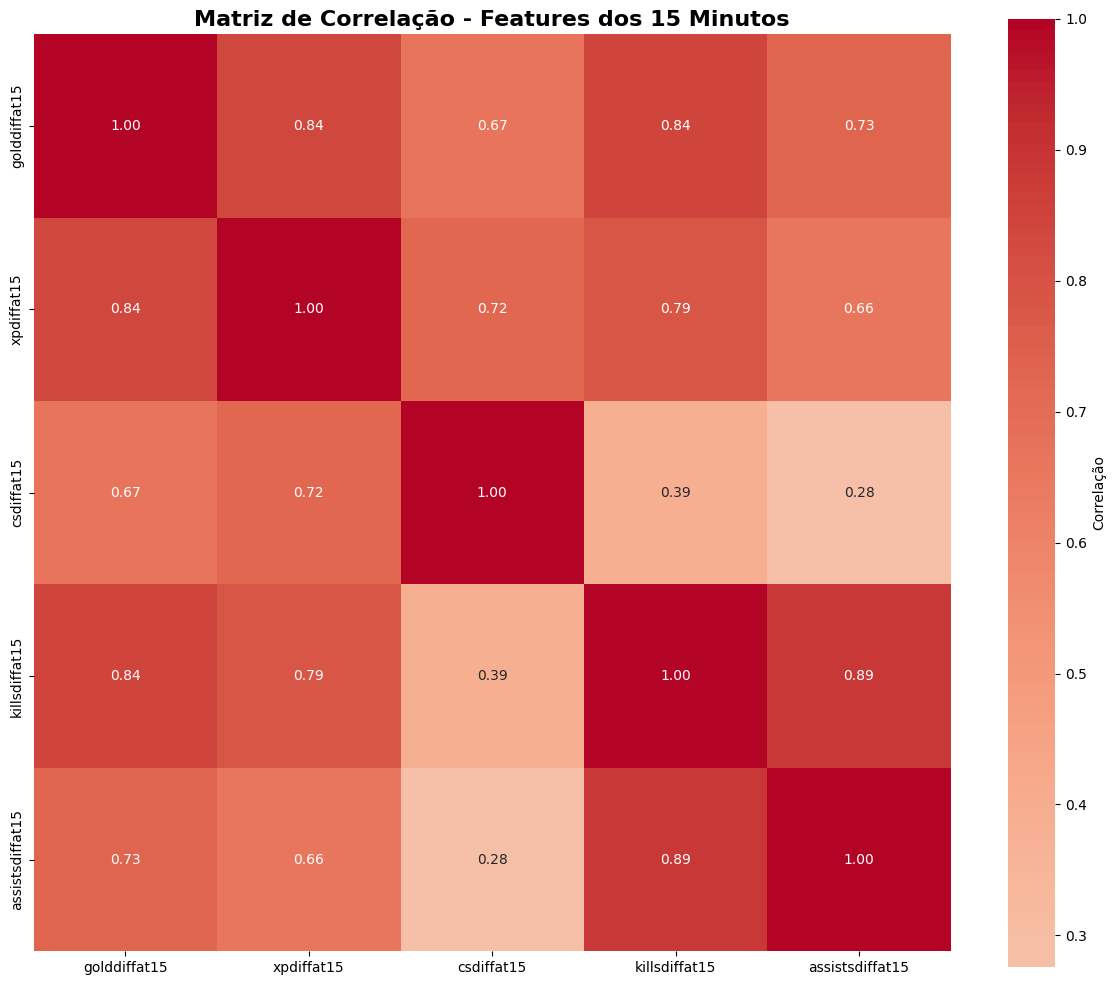


Correlação das features com o resultado:
golddiffat15: 0.5596
xpdiffat15: 0.5096
killsdiffat15: 0.4843
assistsdiffat15: 0.4311
csdiffat15: 0.4027


In [19]:
# Análise descritiva das features utilizadas
print("ANÁLISE DAS FEATURES DOS 15 MINUTOS")
print("=" * 50)

print(f"\nFeatures utilizadas ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")

print("\nEstatísticas das features:")
stats_features = X.describe()
display(stats_features)

# Matriz de correlação
print("\nMatriz de Correlação das Features:")
plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'label': 'Correlação'})
plt.title('Matriz de Correlação - Features dos 15 Minutos', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Features mais correlacionadas com o resultado
print("\nCorrelação das features com o resultado:")
correlacoes_resultado = X.corrwith(y).sort_values(key=abs, ascending=False)
for feature, corr in correlacoes_resultado.items():
    print(f"{feature}: {corr:.4f}")